In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import os
import warnings
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [94]:
#Defining neural network for note classification.
class GaussianNoiseLayer(nn.Module):
    def __init__(self, std=0.1):
        super(GaussianNoiseLayer, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.std
            return x + noise
        return x

class FreqToNote(nn.Module):
    def __init__(self, window_size, hidden_layer):
        super(FreqToNote, self).__init__()

        self.window_size = window_size # 1<<12
        self.hidden_layer = hidden_layer # 100

        self.linear1 = nn.Linear(window_size, hidden_layer)
        self.linear3= nn.Linear(hidden_layer, hidden_layer)
        self.activation = nn.LeakyReLU()
        self.dropOut=nn.Dropout(0.25)
        self.gaussian=GaussianNoiseLayer(std=0.1)
        self.linear2 = nn.Linear(hidden_layer, 12)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.gaussian(x)
        x = self.linear1(x)
        x = self.activation(x)
        for i in range(2):
            x=self.linear3(x)
            x=self.activation(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [47]:
#Creating a custom dataset to load a dataframe into a pytorch dataset.
class CustomDataset(Dataset):
    def __init__(self, frequencies, notes):
        self.frequencies = torch.tensor(frequencies, dtype=torch.float32)
        self.notes = torch.tensor(notes, dtype=torch.float32)  # Adjust the data type as needed

    def __len__(self):
        return len(self.frequencies)

    def __getitem__(self, idx):
        sample = {
            'frequencies': self.frequencies[idx],
            'notes': self.notes[idx]
        }
        return sample

In [48]:
#Bit of preprocessing.
pathToProcessedData='data/'

frequencies=[]
notes=[]
def formatCSV():
    with open(pathToProcessedData+"in.csv", 'r') as file:
        csv_reader = csv.reader(file)
        for line in csv_reader:
            frequencies.append([float(ele) for ele in line])
    with open(pathToProcessedData+"out.csv", 'r') as file:
        csv_reader = csv.reader(file)
        for line in csv_reader:
            notes.append([int(ele) for ele in line])

formatCSV()    

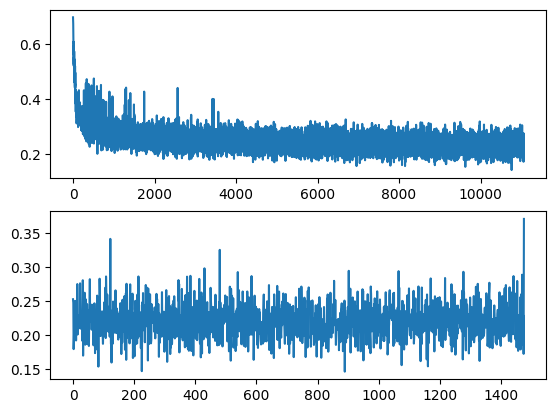

In [96]:
#Initializing model and training parameters.
model = FreqToNote(1 + (1<<10), 100)
fullDataSet=CustomDataset(frequencies, notes)
train_dataset, test_dataset = train_test_split(fullDataSet, test_size=0.4, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

optimizer=torch.optim.Adam(model.parameters())
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
lossFunction=torch.nn.BCELoss()

epochs=10
trainLosses=[]
testLosses=[]
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        inputs, labels =batch["frequencies"], batch["notes"]
        outputs = model(inputs)
        loss = lossFunction(outputs, labels)
        trainLosses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

model.eval()
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch["frequencies"], batch["notes"]
        outputs = model(inputs)
        loss = lossFunction(outputs, labels)
        testLosses.append(loss.item())

fig, axs = plt.subplots(2)
axs[0].plot(range(len(trainLosses)), trainLosses)
axs[1].plot(range(len(testLosses)), testLosses)

In [77]:
torch.onnx.export(
    model,
    torch.randn(1, model.window_size),
    "freq_predictor.onnx",
    opset_version=13,
    input_names=["input"],
    output_names=["output"]
)